In [5]:
import torch
import scipy
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
#from torchmetrics import Precision, Recall, F1Score
import matplotlib.pyplot as plt

In [6]:
device = (
    'cuda:0'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
    )
print("Using device:", device)

Using device: mps


In [7]:
# mean and std of the images
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor()
])
train_data = datasets.Flowers102(root='/Users/maciek/cnn_data', split = 'train', download=True, transform=transform)
train_load = DataLoader(train_data, batch_size = 10, shuffle = False)

# this function gives the approximate mean and std of the dataset
def mean_std(loader):
  mean = 0
  std = 0
  image_count = 0

  for images, _ in loader:
    image_count_batch = images.size(0)
    images = images.view(image_count_batch, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    image_count += image_count_batch

  mean /= image_count
  std /= image_count

  return mean, std

mean, std = mean_std(train_load)
print(mean, std)

tensor([0.4330, 0.3819, 0.2964]) tensor([0.2545, 0.2044, 0.2163])


In [8]:
train_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.4),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])
train_data = datasets.Flowers102(root='/Users/maciek/cnn_data', split = 'train', download=True, transform=train_transform)
val_data = datasets.Flowers102(root='/Users/maciek/cnn_data', split = 'val', download=True, transform=test_transform)
test_data = datasets.Flowers102(root='/Users/maciek/cnn_data', split = 'test', download=True, transform=test_transform)

In [9]:
train_data

Dataset Flowers102
    Number of datapoints: 1020
    Root location: /Users/maciek/cnn_data
    split=train
    StandardTransform
Transform: Compose(
               Resize(size=(112, 112), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
               RandomPerspective(p=0.4)
               ToTensor()
               Normalize(mean=tensor([0.4330, 0.3819, 0.2964]), std=tensor([0.2545, 0.2044, 0.2163]))
           )

In [10]:
val_data

Dataset Flowers102
    Number of datapoints: 1020
    Root location: /Users/maciek/cnn_data
    split=val
    StandardTransform
Transform: Compose(
               Resize(size=(112, 112), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=tensor([0.4330, 0.3819, 0.2964]), std=tensor([0.2545, 0.2044, 0.2163]))
           )

In [11]:
test_data

Dataset Flowers102
    Number of datapoints: 6149
    Root location: /Users/maciek/cnn_data
    split=test
    StandardTransform
Transform: Compose(
               Resize(size=(112, 112), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=tensor([0.4330, 0.3819, 0.2964]), std=tensor([0.2545, 0.2044, 0.2163]))
           )

In [12]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)

In [13]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
        self.batch_norm1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3)
        self.batch_norm2 = nn.BatchNorm2d(256)

        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.batch_norm3 = nn.BatchNorm2d(512)

        self.conv4 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3)
        self.batch_norm4 = nn.BatchNorm2d(1024)

        self.conv5 = nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=3)
        self.batch_norm5 = nn.BatchNorm2d(2048)

        self.pool = nn.MaxPool2d(2, 2)
        #self.avg_pool = nn.AvgPool2d(5, 5)
        
        self.fc1 = nn.Linear(2048 * 1 * 1, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.drop = nn.Dropout(p=0.6)
        
        self.out = nn.Linear(1024, num_classes)

    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batch_norm1(x)
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.batch_norm2(x)
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.batch_norm3(x)
        x = self.pool(x)

        x = F.relu(self.conv4(x))
        x = self.batch_norm4(x)
        x = self.pool(x)

        x = F.relu(self.conv5(x))
        x = self.batch_norm5(x)
        x = self.pool(x)
        #print(f'Shape before pool: {x.shape}')
        #x = self.avg_pool(x)
        #print(f'Shape after pool: {x.shape}')

        x = x.view(-1, 2048 * 1 * 1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.out(x)

        return x

num_classes = 102  # Number of classes in the Oxford Flowers102 dataset

# Create the model
torch.manual_seed(41)
model = CNN(num_classes).to(device)

# Print model summary
print(model)

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm5): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_fea

In [14]:
# loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001) 
# the smaller the lr the longer its gonna take to train but the more accurate it is

In [15]:
#graph parameters
train_list = []
val_list = []

# Early stopping parameters
patience = 7
best_loss = np.inf
counter = 0

# Training loop
num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        running_loss += loss.item() * inputs.size(0)

    # Calculate average training loss
    train_loss = running_loss / len(train_loader.dataset)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Early stopping logic
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break

    # Calculate average validation loss and accuracy
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = correct / total

    # Print training and validation statistics
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {100 * val_accuracy:.2f}%")
    train_list.append(train_loss)
    val_list.append(val_loss)

Epoch 1/300, Train Loss: 4.6495, Val Loss: 4.5976, Val Accuracy: 3.14%
Epoch 2/300, Train Loss: 4.5236, Val Loss: 4.4110, Val Accuracy: 7.35%
Epoch 3/300, Train Loss: 4.4288, Val Loss: 4.2181, Val Accuracy: 9.61%
Epoch 4/300, Train Loss: 4.3195, Val Loss: 4.0652, Val Accuracy: 11.27%
Epoch 5/300, Train Loss: 4.2395, Val Loss: 3.9731, Val Accuracy: 12.84%
Epoch 6/300, Train Loss: 4.1188, Val Loss: 3.8493, Val Accuracy: 13.43%
Epoch 7/300, Train Loss: 4.0570, Val Loss: 3.7534, Val Accuracy: 13.82%
Epoch 8/300, Train Loss: 3.9475, Val Loss: 3.6258, Val Accuracy: 14.80%
Epoch 9/300, Train Loss: 3.9004, Val Loss: 3.6003, Val Accuracy: 17.25%


In [ ]:
# testing the model with the test data
# Testing loop
test_loss = 0.0
correct = 0
total = 0

precision_metric = Precision(num_classes=num_classes, average='macro', task='multiclass')
recall_metric = Recall(num_classes=num_classes, average='macro', task='multiclass')
f1_score_metric = F1Score(num_classes=num_classes, average='macro', task='multiclass')

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        precision_metric(predicted, labels)
        recall_metric(predicted, labels)
        f1_score_metric(predicted, labels)

# Calculate average test loss and accuracy
average_loss = test_loss / len(test_loader)
accuracy = 100 * correct / total

# Calculate the final metrics
final_precision = precision_metric.compute()
final_recall = recall_metric.compute()
final_f1_score = f1_score_metric.compute()

print(f'Average Test Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%')
print(f'final_precision: {final_precision:.2f}, final_recall: {final_recall:.2f}, final_f1_score: {final_f1_score}')

Average Test Loss: 5.1441, Accuracy: 7.53%
final_precision: 0.08, final_recall: 0.09, final_f1_score: 0.07815118134021759


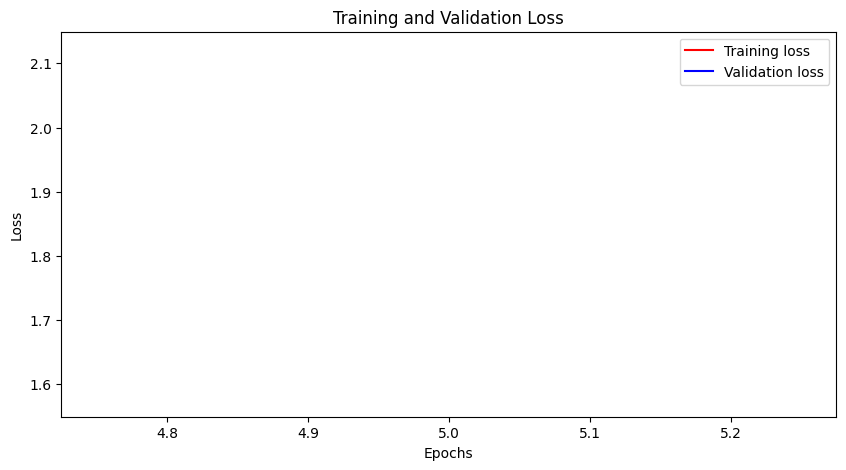

In [ ]:
# Plotting both the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(5, train_loss, 'r', label='Training loss')
plt.plot(5, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()